In [13]:
!pip install efficientnet

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

# Data Augmentation

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [16]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (208,208),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [17]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (208,208),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


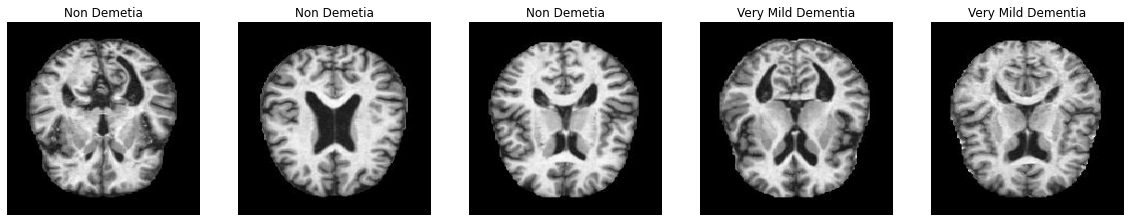

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [20]:
base_model = enet.EfficientNetB0(input_shape=(208,208,3), 
                                 include_top=False,
                                 weights="imagenet")

In [21]:
for layer in base_model.layers:
    layer.trainable=False

In [22]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 1280)        5120      
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 11520)             46080     
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [24]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [25]:
filepath = './model_tuning208_128_Adam1e3.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [26]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.2530 - auc: 0.7419
Epoch 00001: val_auc improved from -inf to 0.67263, saving model to .\model_tuning208_128_Adam1e3.h5
65/65 [==============================] - 253s 4s/step - loss: 1.2530 - auc: 0.7419 - val_loss: 1.2688 - val_auc: 0.6726
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 1.0135 - auc: 0.8234
Epoch 00002: val_auc improved from 0.67263 to 0.74436, saving model to .\model_tuning208_128_Adam1e3.h5
65/65 [==============================] - 206s 3s/step - loss: 1.0135 - auc: 0.8234 - val_loss: 1.1492 - val_auc: 0.7444
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.9020 - auc: 0.8559
Epoch 00003: val_auc did not improve from 0.74436
65/65 [==============================] - 145s 2s/step - loss: 0.9020 - auc: 0.8559 - val_loss: 1.1498 - val_auc: 0.7259
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.8410 - auc: 0.8730
Epoch 00004: val_auc did 

65/65 [==============================] - ETA: 0s - loss: 0.4352 - auc: 0.9660
Epoch 00029: val_auc did not improve from 0.87630
65/65 [==============================] - 143s 2s/step - loss: 0.4352 - auc: 0.9660 - val_loss: 0.9442 - val_auc: 0.8655
Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 0.4479 - auc: 0.9638
Epoch 00030: val_auc did not improve from 0.87630
65/65 [==============================] - 143s 2s/step - loss: 0.4479 - auc: 0.9638 - val_loss: 0.9520 - val_auc: 0.8645
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.4372 - auc: 0.9659
Epoch 00031: val_auc improved from 0.87630 to 0.87700, saving model to .\model_tuning208_128_Adam1e3.h5
65/65 [==============================] - 143s 2s/step - loss: 0.4372 - auc: 0.9659 - val_loss: 0.8894 - val_auc: 0.8770
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.4051 - auc: 0.9710
Epoch 00032: val_auc improved from 0.87700 to 0.89536, saving model to .\model_tuning

Epoch 59/100
65/65 [==============================] - ETA: 0s - loss: 0.3202 - auc: 0.9809
Epoch 00059: val_auc did not improve from 0.92652
65/65 [==============================] - 148s 2s/step - loss: 0.3202 - auc: 0.9809 - val_loss: 0.7749 - val_auc: 0.9094
Epoch 60/100
65/65 [==============================] - ETA: 0s - loss: 0.3159 - auc: 0.9814
Epoch 00060: val_auc did not improve from 0.92652
65/65 [==============================] - 146s 2s/step - loss: 0.3159 - auc: 0.9814 - val_loss: 0.6947 - val_auc: 0.9235
Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.3031 - auc: 0.9828
Epoch 00061: val_auc did not improve from 0.92652
65/65 [==============================] - 147s 2s/step - loss: 0.3031 - auc: 0.9828 - val_loss: 0.7197 - val_auc: 0.9205
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.3189 - auc: 0.9811
Epoch 00062: val_auc did not improve from 0.92652
65/65 [==============================] - 145s 2s/step - loss: 0.3189 - auc: 

Epoch 89/100
65/65 [==============================] - ETA: 0s - loss: 0.2484 - auc: 0.9879
Epoch 00089: val_auc did not improve from 0.94017
65/65 [==============================] - 228s 4s/step - loss: 0.2484 - auc: 0.9879 - val_loss: 0.6518 - val_auc: 0.9339
Epoch 90/100
65/65 [==============================] - ETA: 0s - loss: 0.2649 - auc: 0.9869
Epoch 00090: val_auc did not improve from 0.94017
65/65 [==============================] - 226s 3s/step - loss: 0.2649 - auc: 0.9869 - val_loss: 0.6714 - val_auc: 0.9316
Epoch 91/100
65/65 [==============================] - ETA: 0s - loss: 0.2477 - auc: 0.9886
Epoch 00091: val_auc improved from 0.94017 to 0.94047, saving model to .\model_tuning208_128_Adam1e3.h5
65/65 [==============================] - 227s 3s/step - loss: 0.2477 - auc: 0.9886 - val_loss: 0.6091 - val_auc: 0.9405
Epoch 92/100
65/65 [==============================] - ETA: 0s - loss: 0.2495 - auc: 0.9884
Epoch 00092: val_auc did not improve from 0.94047
65/65 [===============

In [27]:
  base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 208, 208, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 104, 104, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 104, 104, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 104, 104, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

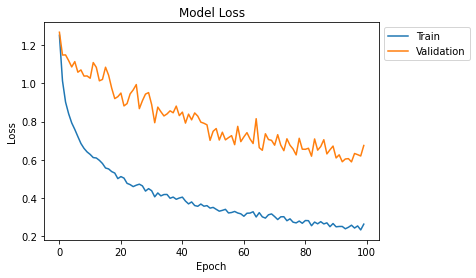

In [28]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

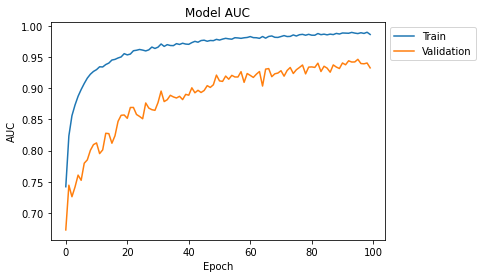

In [29]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

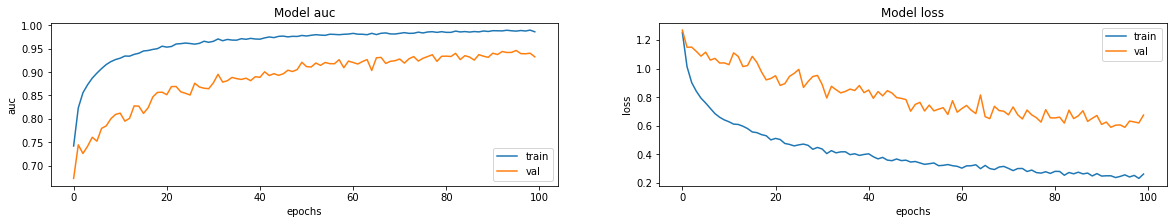

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                 target_size = (208,208),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 1279 images belonging to 4 classes.


In [32]:
model.evaluate(test_dataset)

20/20 [==============================] - 55s 3s/step - loss: 0.7962 - auc: 0.9225


[0.7961910367012024, 0.9225086569786072]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
99.26 % chances are there that the image is NonDemented


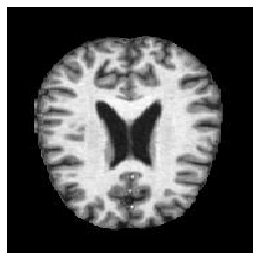

In [33]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

91.21 % chances are there that the image is MildDemented


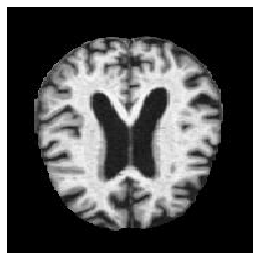

In [34]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

95.02 % chances are there that the image is ModerateDemented


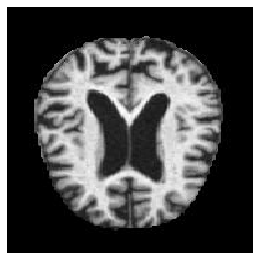

In [35]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

97.49 % chances are there that the image is VeryMildDemented


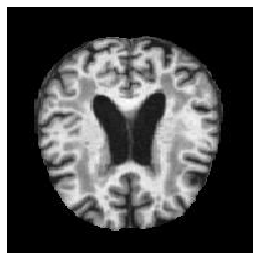

In [36]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])